# MC886 - Projeto 3
Aluno: Mateus Feitosa Olivi  RA: 222059

# Parte 1

<p style="text-align: justify;">
&emsp; Nesta parte do projeto vou aplicar uma técnica de computação evolucionária para resolver o problema do Pac-man. O trabalho consiste em encontrar uma solução adequada para o problema, avaliando-o segundo diversos parâmetros.
</p>

<p style="text-align: justify;">
&emsp; A primeira coisa que preciso fazer é definir um modelo para se aplicar o algoritmo evolucionario, isso é, um modelo que resolve o problema do Pac-man baseando-se em um conjunto de entradas que define um cromossomo. <br>
&emsp; No tópico a seguir vou detalhar como achei o meu modelo:
</p>

### 1. Definição do modelo
<p style="text-align: justify;">
&emsp; Antes de tudo vou importar as dependências para rodar o pacman:
</p>

#### 1.1 Dependências: 

In [4]:
import sys, os
os.chdir(sys.path[0]+'/search')

from pacman import runGames, loadAgent
from pacman import Directions
import pacmanAgents
from util import Queue
import textDisplay
import game
import layout
import random
import graphicsDisplay

import numpy as np 

#### 1.2 Ideia inicial: 

<p style="text-align: justify;">
&emsp; Para definir o modelo usei como inspiração inicial o GreedyAgent, esse agente está definido nos arquivos do pacman, mais precisamente no arquivo pacmanAgents.py, vamos dar uma olhada no que ele faz:
</p>

In [5]:
class GreedyAgent(Agent):
    def __init__(self, evalFn="scoreEvaluation"):
        self.evaluationFunction = util.lookup(evalFn, globals())
        assert self.evaluationFunction != None

    def getAction(self, state):
        # Generate candidate actions
        legal = state.getLegalPacmanActions()
        if Directions.STOP in legal: legal.remove(Directions.STOP)

        successors = [(state.generateSuccessor(0, action), action) for action in legal]
        scored = [(self.evaluationFunction(state), action) for state, action in successors]
        bestScore = max(scored)[0]
        bestActions = [pair[1] for pair in scored if pair[0] == bestScore]
        return random.choice(bestActions)

def scoreEvaluation(state):
    return state.getScore()

<p style="text-align: justify;">
&emsp; Esse código é relativamente simples, no método getAction, inicialmente o agente verifica quais ações ele pode fazer, isso é, quais direção ele pode ir, desconsiderando a possibilidade do pacman ficar parado, para isso o código usa um método já implementado, que é o getLegalPacmanActions(). Após isso, para cada possível direção, o código gera os estados sucessores possíveis, utilizando o método generateSuccessor(). Por fim esse agente verifica qual desses estados tem o melhor score, utilizando a função scoreEvaluation, e então retorna qual é a melhor ação a ser executada para se obter o maior score. <br>
&emsp; Mas note, esse agente é muito simplista, e não pode ser utilizado para se aplicar um algoritmo genético, porém posso modificar ele de tal forma a obter um agente em que poderei aplicar o algoritmo. 

#### 1.3 O meu modelo
<p style="text-align: justify;">
&emsp; No GreedyAgent, o estado é avaliado segundo o score que foi feito, porém isso não é necessariamente bom, já que as vezes o pacman deve fazer desviar de um fantasma, ou então prefirir comer uma capsula ao invés de comer uma comida, ou seja, no meu modelo a avaliação do estado não será baseado, exclusivamente, no score. <br>
&emsp; Essa avaliação pode seguir a lógica de se obter algum bônus por fazer alguma ação positiva que não é contabilizada pelo score, ou seja, o pacman pode obter um bônus por se afastar de um fantasma, por estar perto de um fantasma assustado, por se aproximar de uma capsula, por consumir uma capsula, por consumir um fantasma assustado, por se aproximar de uma comida e por consumir uma comida. <br>
&emsp; Um exemplo para essa lógica: se eu tiver um alto bônus por aproximar de uma comida e um baixo bônus por ficar longe dos fantasmas, o pacman poderá morrer tentando pegar uma comida, porém na situacão oposta, o pacman ira prefirir ficar distantes dos fantasmas do que consumir comidas. <br>
&emsp; Esses bônus poderão ser regulados com pesos que serão dados a eles, esses pesos são os parametros do meu modelo e determinará o grau de importancia para as decisões do pacman.<br>
&emsp; Abaixo vou mostrar como calcularei cada bônus:<br>
&emsp; <b>1)</b> Bônus por se distanciar dos fantasmas (BDF) : A lógica é a seguinte, o pacman deve ser incentivado a ficar longe dos fantasmas, então esse bonus é calculado pela distancia dos fantasmas multiplicado por um peso p1. <br>
&emsp; <b>2)</b> Bônus por se aproximar de capsulas (BAC) : Aqui o pacman deve ser incentivado a se aproximar das capsulas, então esse bonus é calculado pelo negativo da distancia das capsulas multiplicado por um peso p2.<br>
&emsp; <b>3)</b> Bônus por consumir capsulas (BCC) : Aqui o pacman deve ser incentivado a consumir as capsulas, então esse bonus é calculado pela diferença de capsulas entre o estado atual e no próximo, multiplicado por um peso p3.<br>
&emsp; <b>4)</b> Bônus por se aproximar de fantasmas assustados (BAFA) : Aqui o pacman deve ser incentivado a se aproximar de fantamas assustados, então esse bonus é calculado pelo negativo das distancias dos fantasmas assustados multiplicado por um peso p4.<br>
&emsp; <b>5)</b> Bônus por consumir fantasmas assustados (BCFA) : Aqui o pacman deve ser incentivado a consumir os fantasmas assustados, então esse bonus é calculado pela diferença de fantasmas no estado atual e no próximo ,multiplicado por um peso p5.<br>    
&emsp; <b>6)</b> Bônus por se aproximar de alimentos. (BAA) : O pacman deve ser incentivado a se aproximar de comidas, então esse bonus é calculado pelo negativo da distancia da comida mais próxima multiplicado por um peso p6.<br>
&emsp; <b>7)</b> Bônus por consumir alimentos (BCA) : O pacman deve ser incentivado a consumir os alimentos , então esse bonus é calculado pela diferença de alimentos no estado atual e no próximo, multiplicado por um peso p5.<br>
&emsp; Sabendo disso pode-se dizer que a avaliação de um possível estado do jogo sera dado por:<br>
</p>
<p style="text-align: center;">
Avaliação = Score + BDF + BAC + BCC + BAFA + BCFA + BAA + BCA <br>  
</p>
<p style="text-align: justify;">
&emsp; As siglas utilizadas na expressão são as mesmas que foram definidas nas explicações dos bonus. <br>
&emsp; Nesse meu modelo os pesos são extremamente importantes, pois eles que ditarão o quão impactante os bonus são na avaliação do estado, isso porque são os pesos que definem o que é mais importante para o pacman no jogo, por exemplo, se o peso para calcular o bônus por se distanciar dos fantasmas for muito alto, toda ação que o pacman fará será baseada em ficar longe dos fantasmas. Então é importante que se pondere muito bem os pesos.<br>
&emsp; Mas como será definido os pesos? <br>
&emsp; É ai que entra o algoritmo genético, se considerarmos que cada peso é um gene e que um indivíduo/cromossomo é um conjunto dos pesos na forma [p1,p2,p3,p4,p5,p6,p7], então pode-se aplicar um algoritmo genético e achar a melhor combinação de pesos para maximizar o score do pacman.<br>
&emsp; Colocando tudo isso em prática, e codificando esse meu agente obtenho:    

In [6]:
class SmartAgent(game.Agent):    
    def __init__(self, pesos):
        self.pesos = pesos
        
    def getAction(self, state):
        legal = state.getLegalPacmanActions()
        if Directions.STOP in legal: legal.remove(Directions.STOP)
    
        currentState = state
        
        successors = [(state.generateSuccessor(0, action), action) for action in legal]
        evaluated = [(self.evaluation(state, currentState), action) for state, action in successors]
        bestEvaluation = max(evaluated)[0]
        bestActions = [pair[1] for pair in evaluated if pair[0] == bestEvaluation]
        
        return random.choice(bestActions)
        
    def getLegalSteps(self, pos, walls, visited): 
        coluna=pos[0]
        linha=pos[1]
        lista=[]
        
        if(coluna+1 <walls.width):
            if(walls[coluna+1][linha]==False and visited[coluna+1][linha]==0):
                lista.append((coluna+1,linha))
        if(coluna-1 >= 0):
            if(walls[coluna-1][linha]==False and visited[coluna-1][linha]==0):
                lista.append((coluna-1,linha))
        if(linha+1 <walls.height ):
            if(walls[coluna][linha+1]==False and visited[coluna][linha+1]==0):
                lista.append((coluna,linha+1))
        if(linha-1 >= 0):
            if(walls[coluna][linha-1]==False and visited[coluna][linha-1]==0):
                lista.append((coluna,linha-1))
        return lista
    
    def findNearestFood(self, state, posIni):
        walls= state.getWalls()
        foods= state.getFood()
        queue = Queue()
             
        visited = np.zeros((walls.width,walls.height))
        visited[posIni[0]][posIni[1]] = 1
                
        matHeight=foods.height
        matWidth=foods.width
        
        queue.push((posIni, 1))
        while(not queue.isEmpty()):
            current=queue.pop()
            pos=current[0]
            stepsUntilNow=current[1]
            
            if(foods[pos[0]][pos[1]]==True):
                return stepsUntilNow
            
            visited[pos[0]][pos[1]]=1
            possibles=self.getLegalSteps(pos,walls, visited) # pos = (x,y), walls = matriz true/falso, visitados  [(2,2),(2,1),(2,3)]
            for possibleMove in possibles:
                queue.push( (possibleMove, stepsUntilNow+1))
        return -1
    
    def bfsDistance(self, state, posIni, endPos):
        walls= state.getWalls()
        queue = Queue()
        
        
        visited=np.zeros((walls.width,walls.height))
        visited[posIni[0]][posIni[1]]=1
                
        queue.push((posIni, 1))
        while(not queue.isEmpty()):
            current=queue.pop()
            pos=current[0]
            stepsUntilNow=current[1]
            
            if(pos[0] == endPos[0] and pos[1] == endPos[1]):
                return stepsUntilNow
            
            visited[pos[0]][pos[1]]=1
            possibles = self.getLegalSteps(pos,walls, visited) # pos = (x,y), walls = matriz true/falso, visitados  [(2,2),(2,1),(2,3)]
            for possibleMove in possibles:
                queue.push( (possibleMove, stepsUntilNow+1))
        return -1
    
    def ghostDistances(self, state):
        ghostPositions = state.getGhostPositions() 
        pacmanPosition = state.getPacmanPosition()
        
        distancias = []
    
        for i in range(len(ghostPositions)):
            dist = self.bfsDistance(state, pacmanPosition, ghostPositions[i])
            distancias.append(dist)
        
        return distancias
    
    def bonusByGhostDistance(self, peso, distancias, state):
        n_ghosts = len(distancias)
        scared_timer = []

        for i in range(n_ghosts):
            scared_timer.append(state.getGhostStates()[i].scaredTimer)
            
        bonus = 0
        for i in range(n_ghosts):
            if(scared_timer[i] == 0):
                bonus += peso*distancias[i]
        return bonus
    
    def capsuleDistanceBonus(self, peso, state):
        pacmanPosition = state.getPacmanPosition()
        capsulePositions = state.getCapsules() 
        
        bonus = 0
        for capsule in capsulePositions:
            distancia = self.bfsDistance(state, pacmanPosition, capsule)
            bonus -= peso*distancia
        return bonus
    
    def capsuleComsumptionBonus(self, peso, state, currentState):
        capsulePositions = state.getCapsules() 
        numCapsulesCurrentState = len(currentState.getCapsules())

        num_capsulas = numCapsulesCurrentState
        num_capsulas_estado_seguinte = len(capsulePositions)
        
        bonus = (num_capsulas - num_capsulas_estado_seguinte) * peso
        
        return bonus
    
    def countScaredGhosts(self, state):
        total = 0
        for ghost in state.getGhostStates():
            if(ghost.scaredTimer !=0):
                total+=1
        return total
    
    def scaredGhostBonus(self, peso, state, distancias):
        n_ghosts = self.countScaredGhosts(state)
        scared_timer = []

        for i in range(n_ghosts):
            scared_timer.append(state.getGhostStates()[i].scaredTimer)
            
        bonus = 0
        for i in range(n_ghosts):
            if(scared_timer[i] != 0):
                bonus -= peso*distancias[i]
        return bonus
    
    def eatScaredGhosts(self, peso, state, currentState):
        
        currentScaredGhosts=self.countScaredGhosts(currentState)
        scaredGhostsInThisState = self.countScaredGhosts(state)
        
        dif = currentScaredGhosts - scaredGhostsInThisState
        
        bonus=0
        if(dif > 0):
            bonus= peso * dif
        return bonus
    
    def nearestFoodBonus(self, peso, state):
        pacmanPosition = state.getPacmanPosition()
        nearestFoodDistance= self.findNearestFood(state, pacmanPosition)
        bonus = -1* peso * nearestFoodDistance       
        
        return bonus
    
    def eatFoodBonus(self, peso, state, currentState):
        foodMatrix = state.getFood()
        currentFoodMatrix = currentState.getFood()

        diff = currentFoodMatrix.count(True) - foodMatrix.count(True)
        bonus = peso*diff
        
        return bonus
    def evaluation(self, state, currentState):
        
        p1 = self.pesos[0]
        p2 = self.pesos[1]
        p3 = self.pesos[2]
        p4 = self.pesos[3]
        p5 = self.pesos[4]
        p6 = self.pesos[5]
        p7 = self.pesos[6]
        
        score = state.getScore()
        
        distancias_fantasmas = self.ghostDistances(state)
        bonus_distancia_fantasmas = self.bonusByGhostDistance(p1, distancias_fantasmas, state)
        
        bonus_fantasmas_assustados = self.scaredGhostBonus(p2, state, distancias_fantasmas)
        bonus_comer_fantasmas = self.eatScaredGhosts(p3*abs(bonus_fantasmas_assustados) + p3*abs(bonus_distancia_fantasmas), state, currentState)
        
        bonus_comida_proxima =  self.nearestFoodBonus(p4, state)            
        bonus_comer_comida = self.eatFoodBonus(p5*abs(bonus_comida_proxima), state, currentState)  
        
        bonus_distancia_capsula = self.capsuleDistanceBonus(p6, state)
        bonus_consumir_capsula = self.capsuleComsumptionBonus(p7*abs(bonus_distancia_capsula) + p7*abs(bonus_fantasmas_assustados), state, currentState) 
        
        avaliacao = score + bonus_distancia_fantasmas + bonus_distancia_capsula + bonus_consumir_capsula + \
                    bonus_fantasmas_assustados + bonus_comer_fantasmas + bonus_comida_proxima + bonus_comer_comida
        
        return avaliacao

<p style="text-align: justify;">
&emsp; Note que esse agente faz exatamente o que eu planejei, isso é, no getActions são gerados sucessores baseados nas direções possíveis, esses sucessores são avaliados com o método evaluation, e o sucessor escolhido é aquele que obteve melhor avaliação. Essa avaliação segue aquele mesmo esquema de bônus que já expliquei anteriormente. <br>
&emsp; Ainda note que eu as distâncias foram calculadas usando a busca em largura (bfs), nas primeiras versões do meu código eu tinha usado a distância manhattan, porém como ela desconsidera as paredes não achei muito bom. <br>
&emsp; Agora com o agente pronto posso aplicar o algoritmo genético e achar o melhor conjunto de pesos para o executar o agente. <br>

### 2. Algoritmo genético

<p style="text-align: justify;">
&emsp; Para o algoritmo genético irei utilizar a biblioteca geneticalgs, ela pode ser obtida através do pip, porém eu baixei os seus módulos do github oficial <a href="https://github.com/bobirdmi/genetic-algorithms">link aqui</a>. Essa biblioteca faz tudo o que preciso, porém eu tive que modifica-la para obter o valor de maior e menor fitness em cada geração (o que não era feito por padrão), também adicionei um trecho de código para imprimir quando cada geração tiver sido gerada. Uma outra modificação que fiz foi quanto ao elitismo, em aula vimos que no elitismo em uma nova geração são gerados n-1 indivíduos novos e adicionado o indivíduo de melhor fitness da geração anterior, porém nessa biblioteca isso era diferente, nela, quando o elitismo era ativado, a nova geração tinha n indivíduos novos e também o indivíduo de melhor fitness da geração anterior, ou seja, a cada geração a população aumentava em 1 indivíduo, a modificação que fiz foi para que o elitismo ficasse igual o que foi visto em aula (a mudança foi muito simples). A versão modificada da biblioteca está na pasta geneticalgsmod.
</p> 

<p style="text-align: justify;">
&emsp; Vou explicar um pouco do algoritmo que vou utilizar, para isso vou demonstrar em um simples teste, nesse teste vou aplicar o algoritmo genético no meu modelo para o pacman sem nenhum fantasmas presente no layout smallClassic, vamos lá:
</p>

#### 2.1 Treinamento para testar algoritmo
<p style="text-align: justify;">
&emsp; Para aplicar o algoritmo genético preciso definir uma função de fitness, nessa função irei definir os argumentos para executar o pacman e iniciará um jogo, em que o agente será aquele que criei no tópico anterior, ou seja. Os parâmetros dessa minha função será uma lista de pesos e o retorno dela será o score da partida:

In [7]:
def fitfunctionNoGhosts(pesos):
    argumentos ={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout( 'smallClassic' )
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = []
    argumentos['display'] = textDisplay.NullGraphics()
    argumentos['numGames'] = 1
    argumentos['record'] = False
    argumentos['catchExceptions'] = True
    argumentos['timeout'] = 1
    
    res = runGames(**argumentos)
    score = res[0].state.getScore() 

    return score

<p style="text-align: justify;">
&emsp; Função de fitness pronta, agora vou aplicar o algoritmo genético: <br>
</p>

<p style="text-align: justify;">
&emsp; Primeiro vou definir o modelo do algoritmo, nele posso definir os seguintes parâmetros:
</p>

- fitness_func (function): A funcao de fitness será usada 
- optim (str): Qual tipo de fitness será feito, isso é, se iremos maximizar a função de fitness (parâmetro 'max') ou se iremos minimiza-la (parâmetro 'min') .
- selection (str): Tipo de seleção que irá ser feita, "rank", "roulette" ou "tournament".
- tournament_size (int): Define o tamanho do torneio no caso em que 'selection' == 'tournament'.
- mut_prob (float): Probabilidade de ocorrer mutação.
- mut_type (int): Nesse parâmetro se define quantos genes irão sofrer mutação.
- cross_prob (float): Probabilidade de ocorrer crossover.
- cross_type (int): Define o tipo de crossover, singlepoint ( 1 ), doublepoint ( 2 ), multipoint ( > 2 )
- elitism (True, False): Habilita ou desabilita o elitismo.

<p style="text-align: justify;">
&emsp; Agora vou definir algum desses parametros para aplicar o teste, note que usarei RealGA porque os pesos são valores reais:
</p>

In [14]:
import geneticalgsmod as ge

model = ge.RealGA(fitness_func = fitfunctionNoGhosts, 
                  optim='max', 
                  selection="rank", 
                  mut_prob=0.10, 
                  mut_type=1,
                  cross_prob=0.9, 
                  cross_type=2, 
                  elitism=True, 
                  tournament_size=None)

<p style="text-align: justify;">
&emsp; Agora tenho que iniciar uma população, para o teste escolherei uma população de 50 indivíduos, além disso tenho que determinar qual a dimensão do problema (número de genes do meu problema), no meu caso como tenho 7 pesos então será dimensão 7 e por fim preciso definir o intervalo dos meus genes, escolherei um intervalo de [0,10]:

In [17]:
population_size = 50
dimensao = 7         # numero de argumentos da funcao        
interval = (0,10)
model.init_random_population(population_size, dimensao, interval) # iniciando a população

<p style="text-align: justify;">
&emsp; População gerada, note que o código do pacman não fez um monte de print porque eu desabilitei eles no código do jogo. <br>
</p>

&emsp; Agora vou definir o número maximo de gerações e executar o algoritmo:

In [18]:
max_generation = 50
fitness_progress, best_individual, worst_individual = model.run(max_generation)

Geração 1 terminada
Geração 2 terminada
Geração 3 terminada
Geração 4 terminada
Geração 5 terminada
Geração 6 terminada
Geração 7 terminada
Geração 8 terminada
Geração 9 terminada
Geração 10 terminada
Geração 11 terminada
Geração 12 terminada
Geração 13 terminada
Geração 14 terminada
Geração 15 terminada
Geração 16 terminada
Geração 17 terminada
Geração 18 terminada
Geração 19 terminada
Geração 20 terminada
Geração 21 terminada
Geração 22 terminada
Geração 23 terminada
Geração 24 terminada
Geração 25 terminada
Geração 26 terminada
Geração 27 terminada
Geração 28 terminada
Geração 29 terminada
Geração 30 terminada
Geração 31 terminada
Geração 32 terminada
Geração 33 terminada
Geração 34 terminada
Geração 35 terminada
Geração 36 terminada
Geração 37 terminada
Geração 38 terminada
Geração 39 terminada
Geração 40 terminada
Geração 41 terminada
Geração 42 terminada
Geração 43 terminada
Geração 44 terminada
Geração 45 terminada
Geração 46 terminada
Geração 47 terminada
Geração 48 terminada
G

&emsp; Agora vou plotar os gráficos do fitness médio, do melhor fitness e do pior fitness ao longo das gerações:

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotGraph(valores, titulo):
    x1 = list(range(len(valores)))
    plt.plot(x1, valores, 'o')
    plt.xlabel('Gerações', fontsize = 12)
    plt.ylabel('score', fontsize = 12)
    plt.title(titulo,fontsize = 12 )

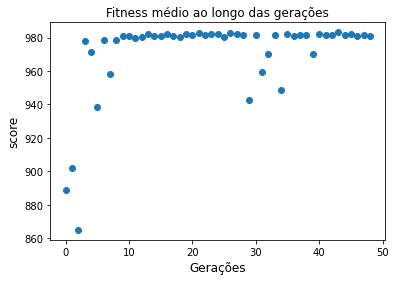

In [54]:
plotGraph(fitness_progress, 'Fitness médio ao longo das gerações')

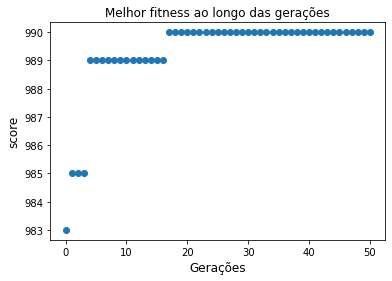

In [48]:
plotGraph(best_individual, 'Melhor fitness ao longo das gerações')

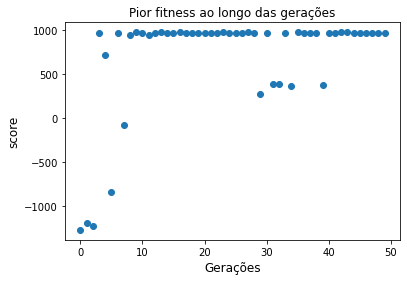

In [55]:
plotGraph(worst_individual, 'Pior fitness ao longo das gerações')

<p style="text-align: justify;">
&emsp; É possível ver que o fitness médio aumentou ao longo das gerações até se estabilizar, e o maior fitness e o menor fitness ficaram muito próximos ao longo das gerações. <br>
&emsp; Agora vou pegar o melhor indivíduo e executar 10 vezes para ver o score, após isso vou executar com a interface gráfica e deixar um gif para mostrar a execução:
</p>

In [81]:
melhor_individuo = model.best_solution[0]
for i in range(10):
    print('Score:', fitfunctionNoGhosts(melhor_individuo))

Score: 984.0
Score: 983.0
Score: 986.0
Score: 971.0
Score: 972.0
Score: 983.0
Score: 983.0
Score: 981.0
Score: 984.0
Score: 985.0


<p style="text-align: justify;">
&emsp; Tive uma consistência bem grande nos scores e além disso o score foi alto para o caso sem os fantasmas. Vou mostrar um gif da execução desse modelo:
</p>

<p style="text-align: center;">
&emsp;<img src="gifs/NoGhosts.gif" width="500" align="center">
</p>

### 3. Treinamento
<p style="text-align: justify;">
&emsp; Agora vou fazer o treinamento incluindo os fantasmas para todos os layouts especificados, que são: smallClassic, mediumClassic e originalClassic. <br>
&emsp; Mas primeiro vou definir os critérios e parâmetros que serão usados para fazer a evolução:<br>
&emsp;-População inicial: Para aplicar o algoritmo genético irei utilizar uma população de 70 indivíduos, como tenho 7 genes em cada cromossomo, pensei que com 70 indivíduos eu terei uma variação de 10 valores diferentes para cada gene.<br>
&emsp;-Critério de parada: Meu critério de parada será o número de gerações, no meu caso vou escolher 40 gerações.<br>
&emsp;-Técnica de seleção: Como critério de seleção irei usar seleção por ranqueamento, como o problema do pacman está relacionado a pegar todas as comidas do tabuleiro com o maior score possível e baseando na maneira na qual eu modelei o problema, não acho que utilizar o ranqueamento me levará há um maxímo local.<br>
&emsp;-Técnica de crossover: irei utilizar um crossover singlepoint.<br>
&emsp;-Técnica de mutação: irei utilizar a técnica padrão da biblioteca que eu escolhi, o método aplicado é o seguinte: se escolhe o número n de genes que será aplicado a mutação e uma probabilidade p de ocorrer a mutação. Com esses dados o algoritmo irá transformar esses n genes em cadeias de bits e cada um desses bits é percorrido, então para cada um desses bits percorrido existe a probabilidade p desse bit ser invertido.<br>
&emsp;-Método de substituição: Irei utilizar o elitismo, em uma nova geração a população terá tamanho n-1 e o melhor indíviduo da geração anterior será transferido para essa nova geração.<br>
&emsp;-Taxa de mutação: Irei definir para a mutação ocorrer em no maxímo 1 gene e com probabilidade de inversão de cada bit de 10%, conforme descrito na Técnica de mutação.<br>
&emsp;-Taxa de crossover: O singlepoint crossover irá ocorrer com probabilidade de 90%.<br>

&emsp; Definidos os parâmetros do algoritmo agora posso aplica-lo para cada layout:

#### 3.1 Layout SmallClassic
&emsp; Primeiro vou definir a função de fitness para esse tabuleiro, que retornará o score da partida e irá definir 2 fantasmas com comportamento aleatório:

In [1]:
def fitfunctionSmallClassic(pesos):
    argumentos ={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout( 'smallClassic' )
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    argumentos['numGames'] = 1
    argumentos['record'] = False
    argumentos['catchExceptions'] = True
    argumentos['timeout'] = 1
    
    res = runGames(**argumentos)
    score = res[0].state.getScore() 

    return score

&emsp; Agora, baseando-se nos parametros escolhidos para aplicar o algoritmo genético vou instanciar um modelo:

In [6]:
import geneticalgsmod as ge

modelSmallClassic = ge.RealGA(fitness_func = fitfunctionSmallClassic, 
                              optim='max',      #Irei maximizar o score
                              selection="rank", #Selecao usarei o ranqueamento
                              mut_prob=0.10,    #Probabilidade de inverter bits na mut de 10%
                              mut_type=1,       #Mutacao ocorrerá em no maxima 1 gene de um cromossomo
                              cross_prob=0.9,   #Prob de ocorrer cross de 90%
                              cross_type=1,     #Cross singlepoint
                              elitism=True,     #Elitismo ativado
                              tournament_size=None)

&emsp; Agora, iniciando uma população de 70 indivíduos e especificando que tenho 7 genes no intervalo de [0,10]:

In [7]:
population_size = 70
dimensao = 7         # numero de argumentos da funcao        
interval = (0,10)
modelSmallClassic.init_random_population(population_size, dimensao, interval) # iniciando a população

&emsp; Agora vou definir o número maxímo de gerações como 40 e aplicar o algoritmo:

In [8]:
max_generation = 40
fitness_progressSC, best_individualSC, worst_individualSC = modelSmallClassic.run(max_generation)

Geração 1 terminada
Geração 2 terminada
Geração 3 terminada
Geração 4 terminada
Geração 5 terminada
Geração 6 terminada
Geração 7 terminada
Geração 8 terminada
Geração 9 terminada
Geração 10 terminada
Geração 11 terminada
Geração 12 terminada
Geração 13 terminada
Geração 14 terminada
Geração 15 terminada
Geração 16 terminada
Geração 17 terminada
Geração 18 terminada
Geração 19 terminada
Geração 20 terminada
Geração 21 terminada
Geração 22 terminada
Geração 23 terminada
Geração 24 terminada
Geração 25 terminada
Geração 26 terminada
Geração 27 terminada
Geração 28 terminada
Geração 29 terminada
Geração 30 terminada
Geração 31 terminada
Geração 32 terminada
Geração 33 terminada
Geração 34 terminada
Geração 35 terminada
Geração 36 terminada
Geração 37 terminada
Geração 38 terminada
Geração 39 terminada
Geração 40 terminada


&emsp; Agora vou plotar os gráficos do fitness médio, do melhor fitness e do pior fitness ao longo das gerações:

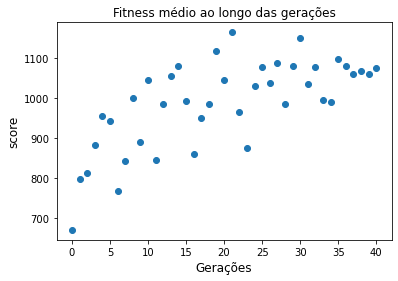

In [9]:
plotGraph(fitness_progressSC, 'Fitness médio ao longo das gerações')

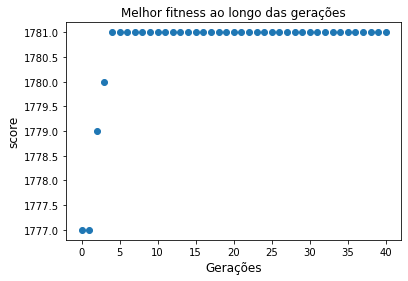

In [10]:
plotGraph(best_individualSC, 'Melhor fitness ao longo das gerações')

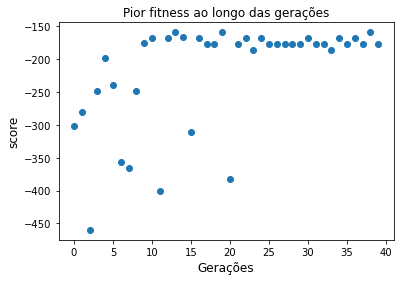

In [11]:
plotGraph(worst_individualSC, 'Pior fitness ao longo das gerações')

<p style="text-align: justify;">
&emsp; Nesses gráfico é possível ver que o fitnesse médio subiu com as gerações, ou seja, a população evoluiu, porém os pontos variam. No gráfico de fitness máximo é possível notar que o score máximo subiu ao longo das gerações e chegou a um valor limite. No gráfico de pior fitness o mesmo foi observado, o pior score subiu ao longo das gerações chegou a um valor em que se estabilizou. <br>
&emsp; Agora vou rodar o melhor individuo 10 vezes para analisar os scores:
</p>

In [16]:
melhor_individuo = modelSmallClassic.best_solution[0]
for i in range(10):
    print('Score:', fitfunctionSmallClassic(melhor_individuo))

Score: 544.0
Score: 1371.0
Score: 1573.0
Score: 1562.0
Score: 1444.0
Score: 1377.0
Score: 1175.0
Score: 1704.0
Score: 200.0
Score: 1372.0


<p style="text-align: justify;">
&emsp; É possível notar que o score variou, de valores baixos até valores altos, mas mesmo assim mantive uma alta média de aproximadamente 1230 de score.
</p>

&emsp; Vou executar o melhor modelo em utilizando a interface gráfica para ter uma ideia melhor de como ficou:

In [36]:
argumentos ={}
pacman = SmartAgent(melhor_individuo)
ghostType = loadAgent('RandomGhost', True)
textDisplay.SLEEP_TIME = 0
argumentos['layout'] = layout.getLayout( 'smallClassic' )
argumentos['pacman'] = pacman
argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
argumentos['display'] = graphicsDisplay.PacmanGraphics(1, frameTime = 0.1)
argumentos['numGames'] = 1
argumentos['record'] = False
argumentos['catchExceptions'] = True
argumentos['timeout'] = 1

res = runGames(**argumentos)

&emsp; Como não consigo colocar a execucao no notebook vou colocar um gif de duas execuções:

<p style="text-align: center;">
&emsp;<img src="gifs/SmallClassic1.gif" width="500" align="center">
</p>

<p style="text-align: justify;">
&emsp; Nessa primeira execução o pacman foi mal, mas o que pode ter acontecido? No momento da morte dele é possível ver que o pacman está indo atrás de um fantasmas assustado então é possível que o peso por se aproximar de um fantasmas assustado esteja maior do que o peso de se afastar de um fantasma não assustado e isso levou a morte do pacman.
</p>

<p style="text-align: justify;">
&emsp; Outra execução:
</p>

<p style="text-align: center;">
&emsp;<img src="gifs/SmallClassic2.gif" width="500" align="center">
</p>

<p style="text-align: justify;">
&emsp; Nessa execução o pacman foi melhor, é possível ver ele indo atrás das capsulas perseguindo, perseguindo fantasmas assustados e evitando os fantasmas não assustados, o que foi muito bom.
</p>

<p style="text-align: justify;">
&emsp; Por que as vezes o pacman vai bem e as vezes mal? O algoritmo genético não foi bem aplicado? <br>
&emsp;A resposta para isso é a estocacidade envolvendo os fantasmas. Como existe essa estocacidade, quando aplicamos o algoritmo genético é possível que sejam selecionados indivíduos que não tem um conjunto de pesos muito bom, mas que obteve um score alto apenas porque teve sorte.<br>
&emsp;Esse fator sorte é um problema bem grande para o algoritmo genético porque isso dificulta a convergencia e faz como que indivíduos não tão bons sejam selecionados para crossover ou então são passados para a próxima geração por elitismo. <br>
&emsp;Mas isso não quer dizer que a população não evolua, claramente observando os gráficos que plotei é possivel notar uma evolução na população, porém não obtive uma média de score constante nas últimas gerações. <br>
&emsp;Se observarmos o modelo sem fantasmas que executei no tópico anterior é possível ver que a população evoluiu muito bem, como a estocacidade dos fantasmas não estava incluida foi facil para neste caso a população evoluir. <br>
&emsp; Uma maneira de melhorar o caso com fantasmas talvez seja colocando o algoritmo para rodar por um número bem grande de gerações, eu tentei fazer isso, mas a memória do meu computador chegou a próximo de 100% de consumo e o kernel do jupyter morreu. <br>
</p>

<p style="text-align: justify;">
&emsp; Agora vou fazer esse mesmo procedimento para o layout mediumClassic:
</p>

#### 3.2 Layout MediumClassic
<p style="text-align: justify;">
&emsp; Para esse layout usarei aqueles mesmos parametros e critérios para o algoritmo genético definidos no início do tópico 3. <br>
&emsp; Mas primeiro vou definir a função de fitness para esse tabuleiro, que retornará o score da partida e irá definir 2 fantasmas com comportamento aleatório:

In [3]:
def fitfunctionMediumClassic(pesos):
    argumentos ={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout( 'mediumClassic' )
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    argumentos['numGames'] = 1
    argumentos['record'] = False
    argumentos['catchExceptions'] = True
    argumentos['timeout'] = 1
    
    res = runGames(**argumentos)
    score = res[0].state.getScore() 

    return score

&emsp; Agora, baseando-se nos parametros escolhidos para aplicar o algoritmo genético no início do tópico 3 vou instanciar um modelo:

In [4]:
import geneticalgsmod as ge

modelMediumClassic = ge.RealGA(fitness_func = fitfunctionMediumClassic, 
                              optim='max',      #Irei maximizar o score
                              selection="rank", #Selecao usarei o ranqueamento
                              mut_prob=0.10,    #Probabilidade de inverter bits na mut de 10%
                              mut_type=1,       #Mutacao ocorrerá em no maxima 1 gene de um cromossomo
                              cross_prob=0.9,   #Prob de ocorrer cross de 90%
                              cross_type=1,     #Cross singlepoint
                              elitism=True,     #Elitismo ativado
                              tournament_size=None)

&emsp; Agora, iniciando uma população de 70 indivíduos e especificando que tenho 7 genes no intervalo de [0,10]:

In [5]:
population_size = 70
dimensao = 7         # numero de argumentos da funcao        
interval = (0,10)
modelMediumClassic.init_random_population(population_size, dimensao, interval) # iniciando a população

&emsp; Agora vou definir o número maxímo de gerações como 40 e aplicar o algoritmo:

In [ ]:
max_generation = 40
fitness_progressMC, best_individualMC, worst_individualMC = modelMediumClassic.run(max_generation)

&emsp; Agora vou plotar os gráficos do fitness médio, do melhor fitness e do pior fitness ao longo das gerações: